In [1]:
# from google.colab import drive
import os

# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/MindEye'
# os.chdir('/content/drive/My Drive/MindEye')

In [2]:
# !pip3 install wandb diffusers
# !pip3 install ftfy regex tqdm
# !pip3 install git+https://github.com/openai/CLIP.git

In [3]:
import torch
import torch.nn as nn
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_image, save_image, encode_img, decode_img, to_PIL
import torch.nn.functional as F
from diffusers.models.vae import Decoder
from diffusers.models import AutoencoderKL
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class Voxel2StableDiffusionModel(torch.nn.Module):
    # define the prototype of the module
    def __init__(self, in_dim=39548, h=2048, n_blocks=4):
        super().__init__()

        self.lin0 = nn.Sequential(
            nn.Linear(in_dim, h, bias=False),
            nn.LayerNorm(h),
            nn.SiLU(inplace=True),
            nn.Dropout(0.5),
        )

        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h, bias=False),
                nn.LayerNorm(h),
                nn.SiLU(inplace=True),
                nn.Dropout(0.3),
            ) for _ in range(n_blocks)
        ])
        
        self.lin1 = nn.Linear(h, 16384, bias=False)
        self.norm = nn.GroupNorm(1, 64)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

        init_weights(self.lin0)
        self.mlp.apply(init_weights)
        init_weights(self.lin1)

        self.upsampler = Decoder(
            in_channels=64,
            out_channels=4,
            up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
            block_out_channels=[64, 128, 256],
            layers_per_block=1,
        )
        for parm in self.upsampler.parameters():
            parm.require_grad = False
        self.upsampler.eval()

    # define how it forward, using the module defined above
    def forward(self, x):
        x = self.lin0(x)
        residual = x
        for res_block in self.mlp:
            x = res_block(x)
            x = x + residual
            residual = x
        x = x.reshape(len(x), -1)
        x = self.lin1(x)
        x = self.norm(x.reshape(x.shape[0], -1, 16, 16).contiguous())
        return self.upsampler(x)

In [6]:
voxel2sd = Voxel2StableDiffusionModel()

In [7]:
voxel2sd.to(device)

Voxel2StableDiffusionModel(
  (lin0): Sequential(
    (0): Linear(in_features=39548, out_features=2048, bias=False)
    (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (2): SiLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (3): Sequential(
      (0): Lin

In [8]:
# some hyperparameters
batch_size = 1
random_seed = 42
train_size = 0.7
valid_size = 1 - train_size
num_workers = torch.cuda.device_count()

In [9]:
# some path information
dataset_path = './dataset/'
training_path = dataset_path + 'subj0{}/training_split/'
training_fmri_path = training_path + 'training_fmri/'
training_images_path = training_path + 'training_images/'
testing_path = dataset_path + 'subj0{}/test_split/test_fmri/'

In [10]:
class MyDataset(Dataset):
  def __init__(self, fmri_data, images_folder, transform=None):
    self.fmri_data = fmri_data
    self.images_folder = images_folder
    self.image_paths = [f"{images_folder}/{filename}" for filename in os.listdir(images_folder)]
    self.transform = transform

  def __len__(self):
    return len(self.fmri_data)

  def __getitem__(self, idx):
    fmri = self.fmri_data[idx]
    image_path = self.image_paths[idx]
    image = load_image(image_path)

    if(self.transform):
      image = self.transform(image)

    return fmri, image

In [11]:
transform = transforms.Resize([512, 512])

# Load dataset, now only subj01
lh = np.load(training_path.format(1) + 'training_fmri/lh_training_fmri.npy')
rh = np.load(training_path.format(1) + 'training_fmri/rh_training_fmri.npy')
lrh = np.concatenate((lh, rh), axis=1)

my_dataset = MyDataset(lrh, training_images_path.format(1), transform=transform)

In [12]:
# train-val split
generator = torch.Generator().manual_seed(random_seed)
trainset, validset = random_split(my_dataset, [train_size, valid_size], generator=generator)

In [13]:
# build dataloader
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in voxel2sd.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in voxel2sd.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [15]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

In [16]:
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=1e-3)
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
#                                            total_steps=num_epochs*((num_train//batch_size)//num_workers),
#                                            final_div_factor=1000,
#                                            last_epoch=-1, pct_start=2/num_epochs)

In [17]:
# epoch = 0
# progress_bar = tqdm(range(epoch, num_epochs), ncols=150)
# losses = []
# val_losses = []
# lrs = []

In [18]:
checkpoint = torch.load('./Models/134')
voxel2sd.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

voxel2sd.eval()

Voxel2StableDiffusionModel(
  (lin0): Sequential(
    (0): Linear(in_features=39548, out_features=2048, bias=False)
    (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (2): SiLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=False)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (3): Sequential(
      (0): Lin

In [19]:
import clip
from PIL import Image

In [20]:
CLIPmodel, preprocess = clip.load("ViT-L/14", device=device)

In [21]:
def similarity(image1_features, image2_features):
    cos = torch.nn.CosineSimilarity(dim=0)
    return cos(image1_features[0],image2_features[0]).item()

In [22]:
def CLIPlatent(image, model, device='cuda'):
  image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
  latent = model.encode_image(image)
  return latent

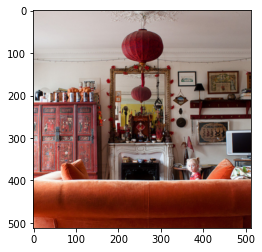

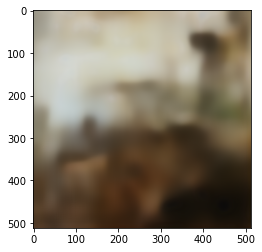

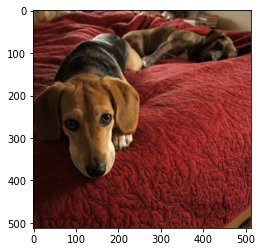

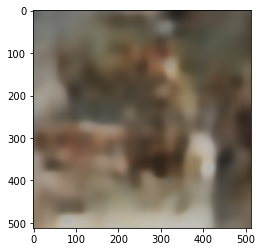

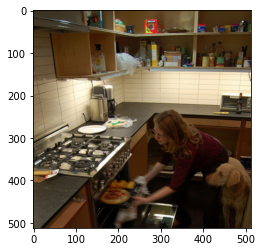

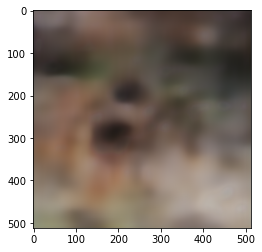

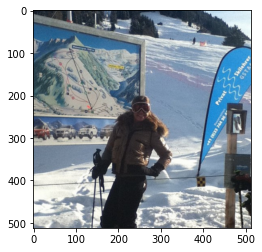

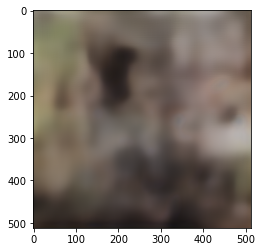

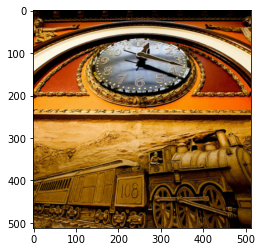

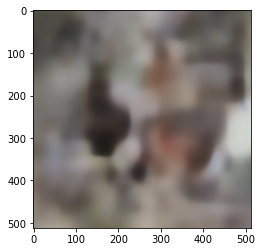

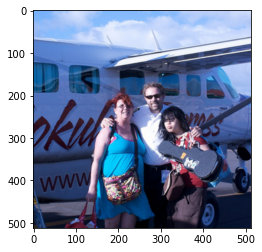

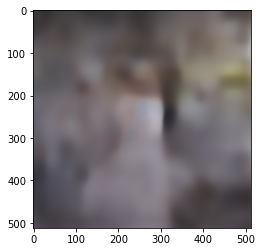

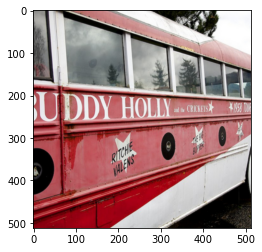

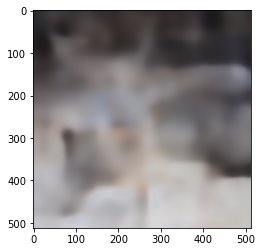

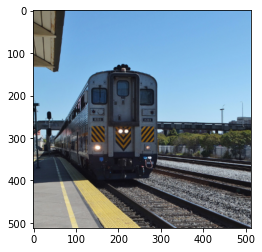

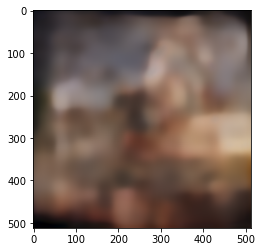

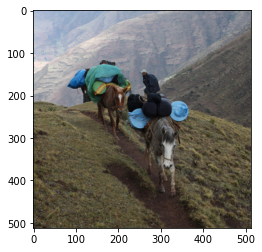

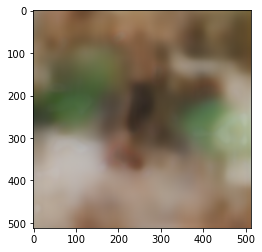

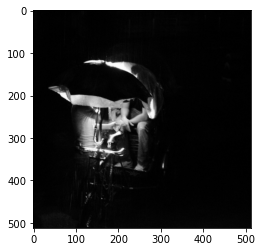

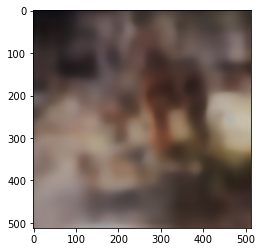

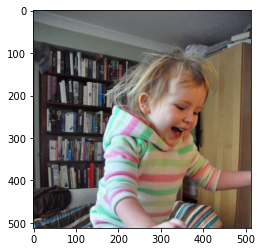

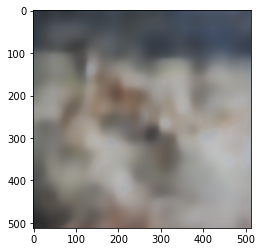

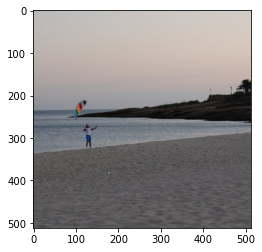

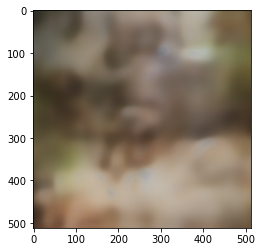

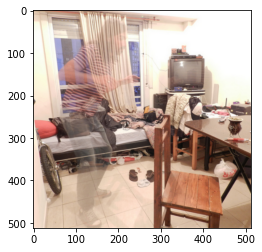

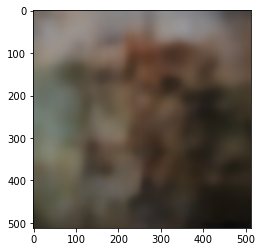

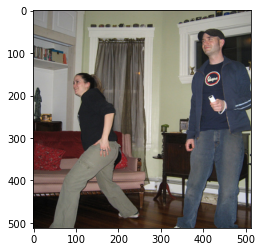

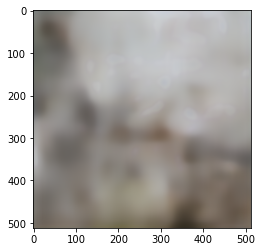

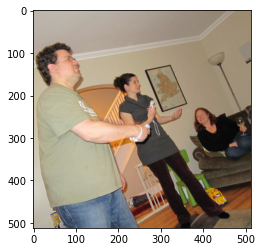

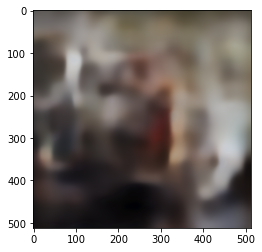

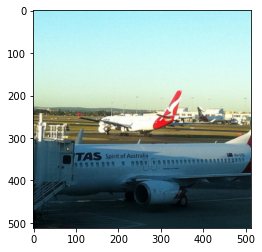

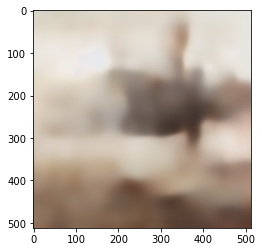

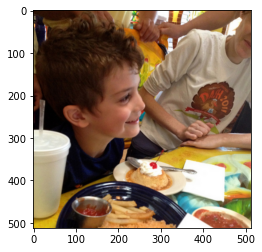

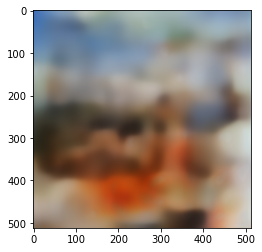

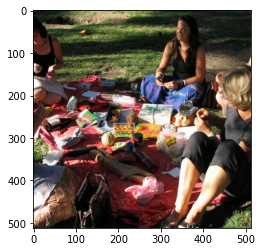

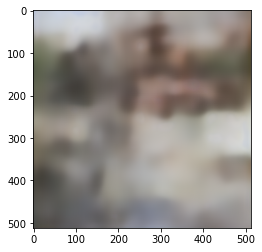

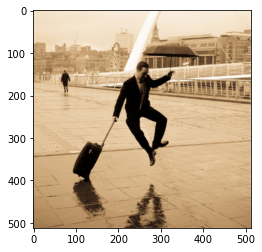

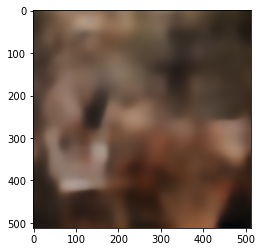

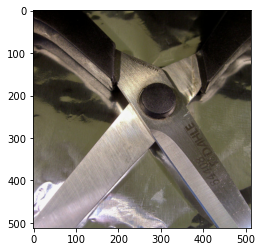

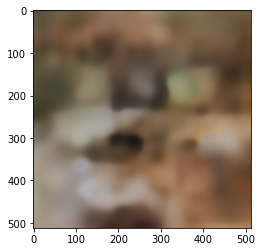

KeyboardInterrupt: 

In [23]:
voxel2sd.eval()
val_loss_sum = 0
max_sim = 0
max_image_latent = None
for val_i, data in enumerate(val_dataloader):
    voxels, images = data
    voxels = voxels.to(device).float()
    images = images.to(device).float()

    # run image encoder
    encoded_latents = torch.cat([encode_img(image, vae.to(device)).to(device) for image in images])
    # plt.imshow(images[0][0].transpose(0, 2).transpose(0, 1).cpu())
    # plt.show()
    # MLP forward
    encoded_predict = voxel2sd(voxels)
    # print(encoded_predict.shape)
    # print(encoded_latents.shape)
    #d = decode_img(encoded_latents.cpu(), vae.cpu())#.to(device)
    decoded_predict = decode_img(encoded_predict, vae)

    # CLIP latent
    image_latent = [CLIPlatent(((np.transpose(image[0].cpu().numpy(), (1, 2, 0)) + 1) / 2 * 255).astype(np.uint8), CLIPmodel) for image in images]
    decode_latent = [CLIPlatent(((np.transpose(image.cpu().numpy(), (1, 2, 0)) + 1) / 2 * 255).astype(np.uint8), CLIPmodel) for image in decoded_predict]

    # calculate similarity
    similarity_sum = 0
    for i in range(len(image_latent)):
        sim = similarity(image_latent[i], decode_latent[i])
        if(sim > max_sim):
            max_sim = sim
            max_image_latent = image_latent[i]
    # show all images

    for image in images:
        plt.imshow(((np.transpose(image[0].cpu().numpy(), (1, 2, 0))) * 255).astype(np.uint8))
        plt.show()
    for image in decoded_predict:
        plt.imshow(((np.transpose(image.cpu().numpy(), (1, 2, 0))) * 255).astype(np.uint8))
        plt.show()

    # calculate loss
    # loss = F.mse_loss(encoded_predict, encoded_latents)
    # val_loss_sum += loss.item()
    # val_losses.append(loss.item())